<a href="https://colab.research.google.com/github/citurriagab/CNN_M6_Trab2/blob/main/KMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Trabajo N° 2

#### Deep Learning 

**Análisis Supervisado**

**Clasificación**

*Carla Iturriaga Barrios*

*Rodrigo Lefin Carrasco*

Septiembre, 2022

### Presentación del proyecto.

*Una empresa de consultoria que presta servicios de traducción, utilizando herramientas de Deep Learning, tiene un nuevo cliente que requiere **identificar letras del japonés clásico pero desde imágenes**.*

**Fuente de datos**: *Dataset correspondiente a imagenes de datos reimpresos del japonés clásico "Kuzushiji" obtenido directamente de la librería pytorch*

### Objetivo del proyecto.

1. *Construir un modelo que sea capaz de clasificar y categorizar en letras del japonés clásico un conjunto de imágenes de la letra desde textos reimpresos.*

### Preparación del entorno

In [55]:
from torchvision import datasets
from torchvision import transforms 
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import datetime
import torchvision
import numpy as np

### 1: Datos

*Los siguientes datos corresponden a una base de 70.000 imagenes de 28x28 con la reimpresión de textos japoneses. La categorización de ellas se divide en 10 clases correspondientes a letras del japonés clásico, tales como: **'o', 'ki', 'su', 'tsu', etc**.*

In [93]:
path = './data/'

# configuración de dataset de entrenamiento y de prueba
df = datasets.KMNIST(path, train=True, download=True)
df_test = datasets.KMNIST(path, train=False, download=True)

In [105]:
# Largo del dataset
print('Registros de entrenamiento:', len(df))
print('Registros de prueba:', len(df_test))

Registros de entrenamiento: 60000
Registros de prueba: 10000


In [101]:
# Especificación de las etiquetas/label
df.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

#### Previsualización de imagenes del dataset

*En adelante, se muestran algunos ejemplares de los registros del dataset KMNIST, correspondiente a la letra en compañía con su etiqueta o clase*

la siguiente imagen corresponde al label: 5 correspondiente a: ha


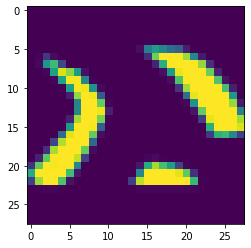

In [102]:
#Previsualización de una imagen dentro del dataset
img, label = df[10]
plt.imshow(img)
print('la siguiente imagen corresponde al label:', label, 'correspondiente a:', df.classes[label])
plt.show()

la siguiente imagen corresponde al label: 2 correspondiente a: su


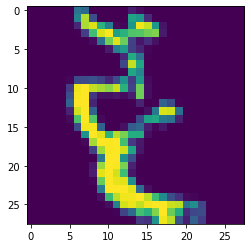

In [103]:
#Previsualización de una imagen dentro del dataset
img2, label2 = df[90]
plt.imshow(img2)
print('la siguiente imagen corresponde al label:', label2, 'correspondiente a:', df.classes[label2])
plt.show()

la siguiente imagen corresponde al label: 3 correspondiente a: tsu


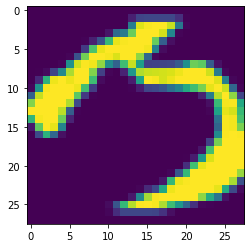

In [104]:
#Previsualización de una imagen dentro del dataset
img3, label3 = df[25000]
plt.imshow(img3)
print('la siguiente imagen corresponde al label:', label3, 'correspondiente a:', df.classes[label3])
plt.show()

#### Transformación y Normalización de imagenes a tensor de PyTorch

*Para seguir con el análisis y modelamiento, es requerido transformar los registros del dataset desde imágenes a tensores y, posteriormente, normalizar sus medidas de promedio y desviación estándar*

In [112]:
# Transformar data a tensor de pytorch y normalizar
df = datasets.KMNIST(
    path, train=True, download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        transforms.Normalize((0.5,),(0.5,)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        
    ])
)

df_test = datasets.KMNIST(
    path, train=False, download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        transforms.Normalize((0.5,),(0.5,)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))

    ])
)

#### Información del dataset

In [108]:
print('Entrenamiento: ', df)

Entrenamiento:  Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train


In [109]:
print('Prueba: ', df_test)

Prueba:  Dataset KMNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test


#### Visualización de los registros transformados en Tensores

*En adelante, se genera una demostración gráfica del nuevo registro tensor*

La siguiente imagen corresponde al label: 5 correspondiente a: ha


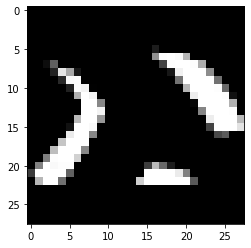

In [114]:
# Graficar la imagen transformada
img_t, label = df[10]
#plt.imshow(img_t.permute(1,2,0))
plt.imshow(torchvision.utils.make_grid(img_t, nrow=5).permute(1, 2, 0))
print('La siguiente imagen corresponde al label:', label, 'correspondiente a:', df.classes[label])
plt.show()

### 2. Modelo

*Dado el tipo de registros (imágenes) e información con la que se está trabajando en el presente proyecto, se decide configurar y entrenar el modelo **CNN** (Convolutional Neural Network)*

*Para ello, se desarrolla, a continuación, la red neuronal con **2 hiden layers**, donde el registro de entrada al primer layer corresponde a un input de 3 dimensiones y la última **salida correspondería a 10 clases**.*

In [115]:
# Model 
class CNN(nn.Module):
    """Cada arquitectura es una forma funcional de la red."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # convolutional layer
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # convolutional layer
        self.fc1 = nn.Linear(8 * 8 * 8, 32)                     # Fully connected
        self.fc2 = nn.Linear(32, 10)                             # Fully connected

    def forward(self, x): # input img
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)        # max pooling
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)      # max pooling
        out = out.view(-1, 8 * 8 * 8)                           # tranform the out
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out  # dim: number of class

*En la siguiente **función de entrenamiento**, queda definido genericamente el proceso en bucle al que deben someterse las imágenes/tensores para entrenar el modelo, donde se tiene como input la cantidad de iteraciones (epochs), el modelo (CNN), optimizador, la función de error y la definición de los batches*

In [65]:
# Training function 
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 
        for imgs, labels in train_loader:  # batch 
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()               # backpro
            optimizer.step()              # update w
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format(epoch,
            loss_train / len(train_loader)))
            loss_list.append(loss_train / len(train_loader))
    return loss_list
            

#### Entrenando el modelo...

*Ya con el modelo y las funciones definidas, el set de datos KMNIST debe entrenar el modelo, donde:*

* *El **modelo** definido, como anteriormente se mencionó es el de **Convolutional Neural Network**, dado que los registros pertenecen a la categoria **imagenes**.*

* *El **Optimizador** definido será **Adam**, dado que al ser una versión más actual y al estar construido en base a SGD, se espera un rendimiento superior en sus restulados*

* *En cuanto a la **Función de pérdida**, se utilizará **Cross Entropy** ya que este proyecto es de clasificación*

**Hiperparámetros (W)**

*En términos de los hiperparametros del modelo CNN:*

- **Batches**: Se optará por **32**, para la división de la base de datos.

- **Learning Rate (lr)**: Este se definirá como **0.01**, con la intención de búsqueda del valor óptimo en una rapidez mediana.

- **Epochs**: La cantidad de iteraciones serán **50**, dado que se requiere un número alto para la búsqueda del valor óptimo y disminuir lo más posible el error.

In [119]:
# Dataloader
train_loader = torch.utils.data.DataLoader(df, batch_size=32, shuffle=True)

In [118]:
# Run, traning
model = CNN()                                      # call our cnn class
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Stochastic gradient descent
loss_fn = nn.CrossEntropyLoss()                    # Loss function

Loss1 = training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)



RuntimeError: ignored

#### Visualización de la función de pérdida (Loss F.)

*El siguiente gráfico presenta la curvatura que va tomando el error al avanzar las iteraciones del modelo (epochs), de ello se puede mencionar que:*

*En primera instancia, los errores toman valores altos que van disminuyendo al iterar cada vez más, ............"llegando a la iteración XXXX, loss function toma un valor que se puede considerar como óptimo...............*

In [81]:
# plot loss
plt.plot(Loss1)
plt.xlabel('Epoch(x10)')
plt.ylabel('Loss')

NameError: ignored

### 3. Métricas y Resultados

**Métricas.**

*Dentro de las métricas a calcular en el presente proyecto para definir qué tan bueno es el modelo desarrolado, se tienen las siguientes:*

- Accuracy

- F1

- AUC

- Precision

- Recall

In [83]:
# Testing metric
train_loader = torch.utils.data.DataLoader(df, batch_size=32,
                                            shuffle=False)
test_loader = torch.utils.data.DataLoader(df_test, batch_size=32,
                                            shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                # metrics: Acc, F1, AUC, Precision, Recall, 
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        #print("F1 Score: ....")
        #print("AUC: .......")
        #print("Precision: ....")
        #print("Recall: .......")

validate(model, train_loader, test_loader)


RuntimeError: ignored

*De acuerdo a los resultados anteriores, se define que el modelo CNN construido para clasificar en letras del japonés clásico imagenes de texto reimpreso es ......................... BUENO/MALO ......................., esto fundamentado en los valores de:*

*  .......................... "Accuracy" que obtuvo un valor XXXXXX, indicando que es capaz de acertar en el XX% de los casos......................*

* *Por otro lado, se puede mencionar, también, que F1 Score alcanza un nivel de .................XX, traduciendose en que el modelo ............(relacionarlo con las imagenes y letras japonesas)..................................*

* ....................."otras metricas*.............................